Household Electricity Consumption Usage Time Series Analysis
---

Author - Ibidokun


---

The data looks contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years; the data is initially untidy, and will take a lot of cleaning. 

We will conduct the time series analysis, correlation between the data and then construct an Autoregressive Model to predict future values. Also, building ARIMA and SARIMA model in this notebook.

### Data Description

The dataset is multivariate time series and was collected between December 2006 and November 2010 and observations were collected every minute containing  seven variables (besides the date and time) which are the following:

- global_active_power: The total active power consumed by the household (kilowatts).
- global_reactive_power: The total reactive power consumed by the household (kilowatts).
- voltage: Average voltage (volts).
- global_intensity: Average current intensity (amps).
- sub_metering_1: Active energy for kitchen (watt-hours of active energy).
- sub_metering_2: Active energy for laundry (watt-hours of active energy).
- sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

Active and reactive energy refer to the technical details of alternative current.

### Import the required libraries

In [1]:
import math
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
from sklearn import preprocessing 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import datetime

sns.set_style('darkgrid')
%matplotlib inline

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from numpy import nan

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Bidirectional ,Conv1D, Dropout, MaxPooling1D, ConvLSTM2D, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
def prepare_dataset():
    # Load all data.
    dataset = pd.read_csv('/Users/carolynesalcido/Downloads/household_power_consumption.txt', sep=';', header=0, low_memory=False, parse_dates={'datetime' : ['Date', 'Time']}, infer_datetime_format=True, index_col=['datetime'])

    # Mark all missing values.
    dataset.replace('?', np.nan, inplace=True)
    # Make dataset numeric.
    dataset = dataset.astype(np.float32)

    # Add a column for for the remainder of sub metering.
    values = dataset.values

    # Save updated dataset
    dataset.to_csv('household_power_consumption.csv')

def resample_dataset():
    # Load the new file
    dataset = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

    # Resample minute data to total for each day.
    daily_groups = dataset.resample('D')
    daily_data = daily_groups.sum()

    # summarize.
    print(daily_data.shape)

    # Save.
    daily_data.to_csv('household_power_consumption_days.csv')
    ## Changing the data types to correct format
    daily_data['Global_active_power'] = pd.to_numeric(daily_data['Global_active_power'])
    daily_data['Global_reactive_power'] = pd.to_numeric(daily_data['Global_reactive_power'])
    daily_data['Voltage'] = pd.to_numeric(daily_data['Voltage'])
    daily_data['Global_intensity'] = pd.to_numeric(daily_data['Global_intensity'])
    daily_data['Sub_metering_1'] = pd.to_numeric(daily_data['Sub_metering_1'])
    daily_data['Sub_metering_2'] = pd.to_numeric(daily_data['Sub_metering_2'])
    daily_data['Sub_metering_3'] = pd.to_numeric(daily_data['Sub_metering_3'])

    daily_data.replace('?', nan, inplace=True)

    for j in range(0,7):        
        daily_data.iloc[:,j]=daily_data.iloc[:,j].fillna(daily_data.iloc[:,j].mean())
    daily_data.isnull().sum()
    print(daily_data.info())

    return daily_data

# Split a univariate dataset into train/test sets.
def split_dataset(data):
    # Split into standard weeks.
    train, test = data[1:-328], data[-328:-6]
    # Restructure into windows of weekly data.
    train = np.array(np.split(train, len(train) / 7))
    test = np.array(np.split(test, len(test) / 7))
    print('Train Size : ', train.shape)
    print('Test Size : ', test.shape)
    
    return train, test

In [3]:
prepare_dataset()

In [5]:
daily_data = resample_dataset()
daily_data.head()

(1442, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 7 columns):
Global_active_power      1442 non-null float64
Global_reactive_power    1442 non-null float64
Voltage                  1442 non-null float64
Global_intensity         1442 non-null float64
Sub_metering_1           1442 non-null float64
Sub_metering_2           1442 non-null float64
Sub_metering_3           1442 non-null float64
dtypes: float64(7)
memory usage: 90.1 KB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


### Define helper functions

In [6]:
# Evaluate one or more weekly forecasts against expected values.
def evaluate_forecasts(actual, predicted):
    # Calculate an RMSE score for each day.
    scores = list()
    for i in range(actual.shape[1]):
        # Calculate MSE.
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # Calculate RMSE.
        rmse = math.sqrt(mse)
        # Store.
        scores.append(rmse)

    # Calculate overall RMSE.
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))

    return score, scores

# Summarize scores.
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# Convert history into inputs and outputs.
def to_supervised(train, n_input, n_out=7):
    # Flatten data.
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time.
    for _ in range(len(data)):
        # Define the end of the input sequence.
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Ensure we have enough data for this instance.
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # Move along one time step.
        in_start += 1
    return np.array(X), np.array(y)

# Convert history into inputs and outputs
def to_supervised_for_multivariate(train, n_input, n_out=7):
    # Flatten data.
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time.
    for _ in range(len(data)):
        # Define the end of the input sequence.
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Ensure we have enough data for this instance.
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # Move along one time step.
        in_start += 1
    return np.array(X), np.array(y)


# Make a forecast.
def forecast(model, history, n_input):
    # Flatten data.
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # Retrieve last observations for input data.
    input_x = data[-n_input:, 0]
    # Reshape into [1, n_input, 1].
    input_x = input_x.reshape((1, len(input_x), 1))

    # Forecast the next week.
    yhat = model.predict(input_x, verbose=0)

    # We only want the vector forecast.
    yhat = yhat[0]
    return yhat

# Evaluate a single model.
def evaluate_model(model, forecast_func, train, test, n_input):

    # History is a list of weekly data.
    history = [x for x in train]

    # Walk-forward validation over each week.
    predictions = list()
    for i in range(len(test)):
        # Predict the week.
        yhat_sequence = forecast_func(model, history, n_input)
        # Store the predictions.
        predictions.append(yhat_sequence)
        # Get real observation and add to history for predicting the next week.
        history.append(test[i, :])

    # Evaluate predictions days for each week.
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def learning_curve(history):
    plt.style.use('seaborn-dark-palette')
    plt.figure(figsize=(17, 7))

    plt.plot(history.history["loss"], label="training")
    plt.plot(history.history["val_loss"], label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss -Mean Squared Error")
    plt.legend()

    plt.show()
    
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
def get_mean_rmse_and_plot_rmse(scores, days):
    print('Mean Test RMSE Score : ', np.round(scores[0],5))
    print('RMSE for each Weekday')
    plt.figure(figsize = (17,6))
    plt.plot(days, scores[1], marker='o', label='LSTM model with univariate input and vector output') 
    plt.show()

### Scale the dataset and Split into train and test

In [7]:
values = daily_data.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
train, test = split_dataset(scaled)

Train Size :  (159, 7, 7)
Test Size :  (46, 7, 7)


## Model 1 

#### LSTM model

LSTM model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 119       
Total params: 77,543
Trainable params: 77,543
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0291 - val_loss: 0.0065
E

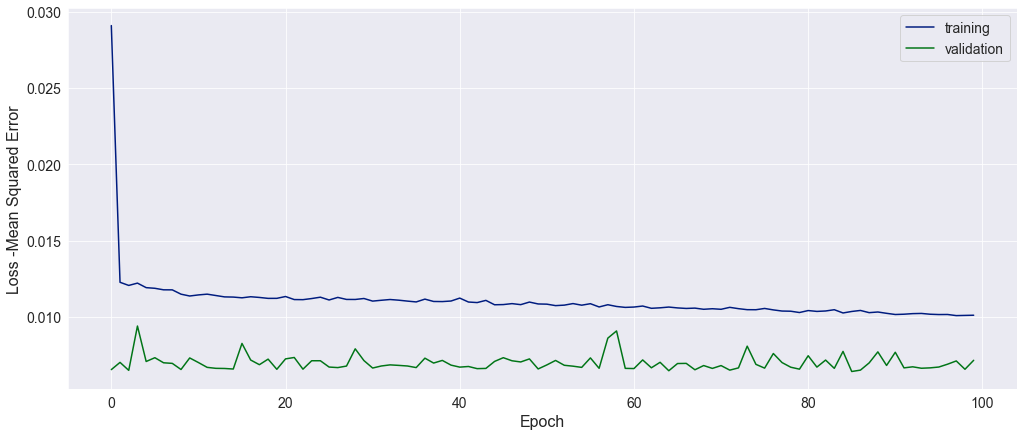

Mean Test RMSE Score :  0.09664
RMSE for each Weekday


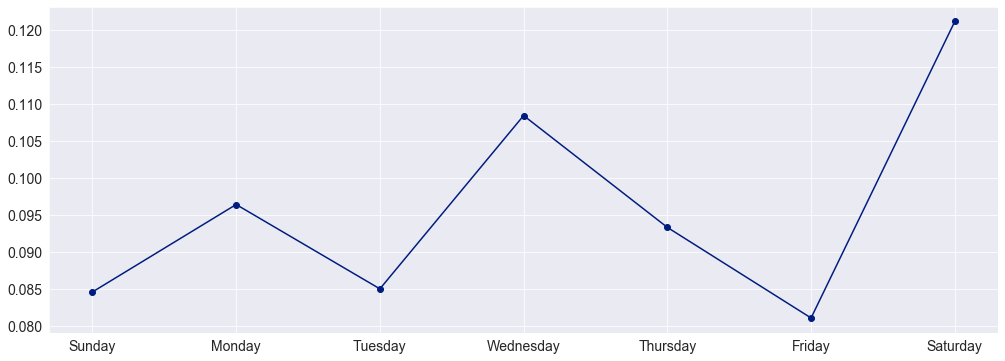

In [9]:
def build_lstm_model(train):

    # Define model.
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    # Fit network.
    return model

print("LSTM model")
print("==========")

n_input = 7
# Prepare data.
train_x, train_y = to_supervised(train, n_input)


# Define parameters.
verbose, epochs, batch_size = 1, 100, 8
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

univariate_LSTM =  build_lstm_model(train, )

history = univariate_LSTM.fit(train_x, train_y, epochs=epochs, validation_split = 0.1, batch_size=batch_size, verbose=verbose)

learning_curve(history)

scores = evaluate_model(univariate_LSTM, forecast, train, test, 7)
get_mean_rmse_and_plot_rmse(scores, days)

## Model 2

#### Encoder-Decoder LSTM model

Encoder Decoder LSTM model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 64)             49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 16)             1040      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              17        
Total params: 117,025
Trainable params: 117,025
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
124/124 [==============================] - 2s 14ms/step - loss: 0.0214

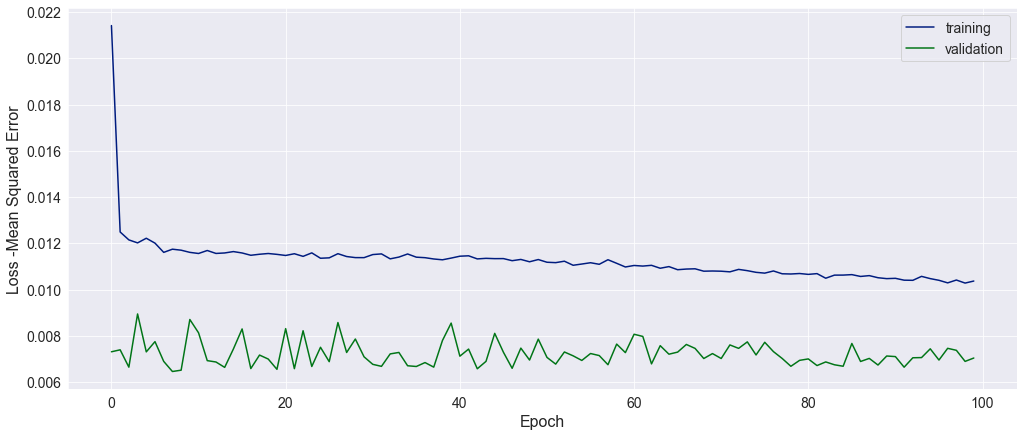

Mean Test RMSE Score :  0.09397
RMSE for each Weekday


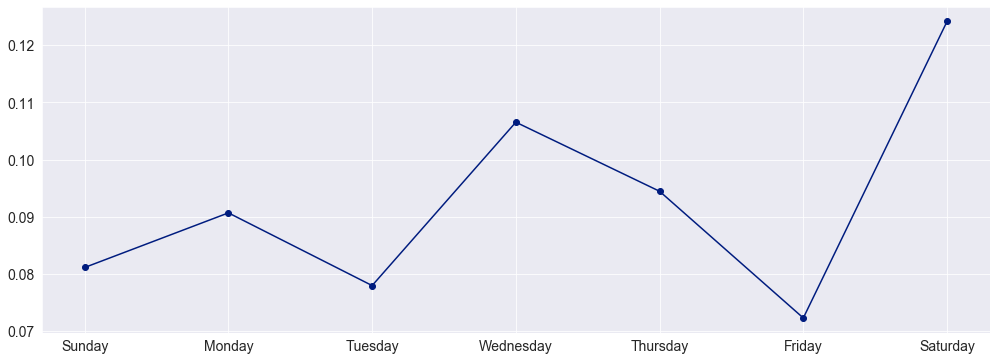

In [12]:
def build_encdec_lstm_model(train):
   # Define model.
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(64, return_sequences=True))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model


print("Encoder Decoder LSTM model")
print("==========================")

univariate_encdec_LSTM =  build_encdec_lstm_model(train)

history = univariate_encdec_LSTM.fit(train_x, train_y, epochs=epochs, validation_split = 0.1, batch_size=batch_size, verbose=verbose)

learning_curve(history)

scores = evaluate_model(univariate_encdec_LSTM, forecast, train, test, 7)
get_mean_rmse_and_plot_rmse(scores, days)

## Model 3

#### CNN-LSTM Encoder-Decoder model

CNN-LSTM Encoder-Decoder model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 64)             12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 200)            212000    
_________________________________________________________________
time_distributed_2 (Tim

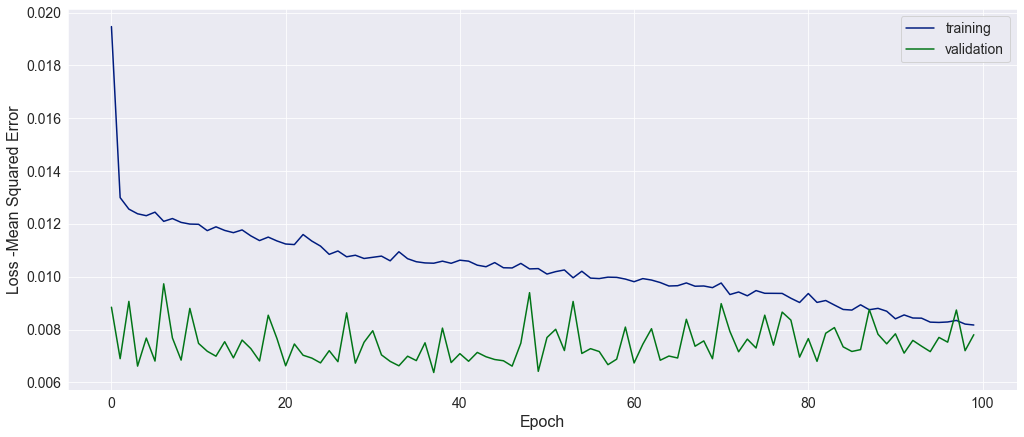

Mean Test RMSE Score :  0.10567
RMSE for each Weekday


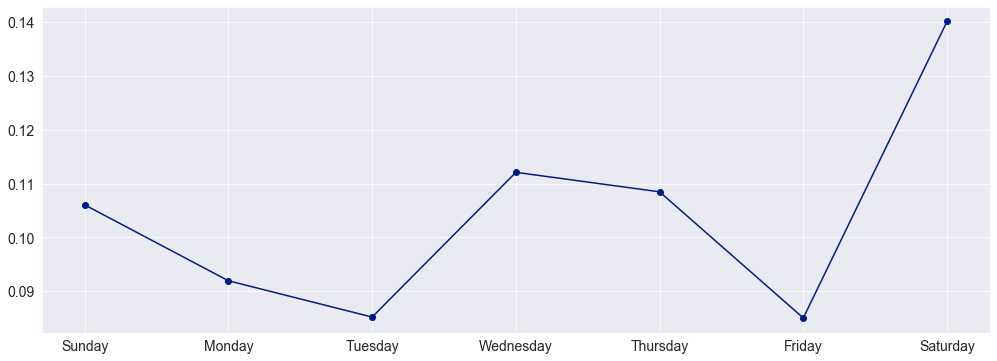

In [13]:
def build_encdec_cnn_lstm_model(train):
    # Define model.
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model


# Prepare data.
train_x, train_y = to_supervised(train, n_input)
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# Reshape output into [samples, timesteps, features].
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

print("CNN-LSTM Encoder-Decoder model")
print("==============================")

univariate_encdec_CNN_LSTM =  build_encdec_cnn_lstm_model(train)

history = univariate_encdec_CNN_LSTM.fit(train_x, train_y, epochs=epochs, validation_split = 0.1, batch_size=batch_size, verbose=verbose)

learning_curve(history)

scores = evaluate_model(univariate_encdec_CNN_LSTM, forecast, train, test, 7)
get_mean_rmse_and_plot_rmse(scores, days)

## Model 4

#### Bidirectional LSTM

In [ ]:
def BiDirectioanl_CNN_LSTM():
    
    # Define model.
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps,n_features),activation='relu', return_sequences = True)))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Bidirectional(LSTM(256, input_shape=(n_timesteps,n_features),activation='relu', return_sequences = True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, input_shape=(n_timesteps,n_features),activation='relu', return_sequences = True)))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='tanh'))
    model.add(Flatten())
    model.add(Dense(7,activation='linear'))          
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model

# Prepare data.
train_x, train_y = to_supervised(train, n_input)
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# Reshape output into [samples, timesteps, features].
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))

print("CNN-LSTM Bi-Directional Model.")
print("==============================")

BiDirectioanl_CNN_LSTM =  BiDirectioanl_CNN_LSTM()

history = BiDirectioanl_CNN_LSTM.fit(train_x, train_y, epochs=epochs, validation_split = 0.1, batch_size=batch_size, verbose=verbose)

learning_curve(history)
scores = evaluate_model(BiDirectioanl_CNN_LSTM, forecast, train, test, 7)
get_mean_rmse_and_plot_rmse(scores, days)

CNN-LSTM Bi-Directional Model.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 5, 64)             256       
_________________________________________________________________
bidirectional (Bidirectional (None, 5, 256)            197632    
_________________________________________________________________
dropout (Dropout)            (None, 5, 256)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 64)             49216     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 3, 512)            657408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 512)            0         
_________________________________________________________________
bidirectional_2 (Bidire

Encoder-Decoder LSTM model seems to be performing the best.. with average RMSe of 0.094 as compared to the other models.